# Product Amount Forecast by Time

## Data

Info about this data set: https://fred.stlouisfed.org/series/IPN31152N


Units:  Index 2012=100, Not Seasonally Adjusted

Frequency:  Monthly

The industrial production (IP) index measures the real output of all relevant establishments located in the United States, regardless of their ownership, but not those located in U.S. territories.

NAICS = 31152

Source Code: IP.N31152.N

Suggested Citation:
Board of Governors of the Federal Reserve System (US), Industrial Production: Nondurable Goods: Ice cream and frozen dessert [IPN31152N], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/IPN31152N, November 16, 2019.

## Import Libraries

In [110]:
import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns 
import matplotlib.pyplot as plt

%matplotlib inline
# %matplotlib notebook
plt.rcParams["figure.figsize"] = (12,6)
# plt.rcParams['figure.dpi'] = 100
sns.set_style("whitegrid")
import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")
pd.set_option('display.float_format', lambda x: '%.3f' % x)

pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

## Indest Data

In [112]:
df = pd.read_csv('Frozen_Dessert_Production.csv', parse_dates=True, index_col='DATE')
df

,IPN31152N
DATE,
1972-01-01,59.962
1972-02-01,67.061
1972-03-01,74.235
1972-04-01,78.112
1972-05-01,84.764
...,...
2019-05-01,114.561
2019-06-01,124.960
2019-07-01,110.263


## Exploratory Data Analysis and Visualization

1. Implement basic steps to see how is your data looks like
2. Change the column name as "Production"
2. Plot your data and see its seasonalty

In [113]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 573 entries, 1972-01-01 to 2019-09-01
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   IPN31152N  573 non-null    float64
dtypes: float64(1)
memory usage: 9.0 KB


In [114]:
df.columns = ['Production']

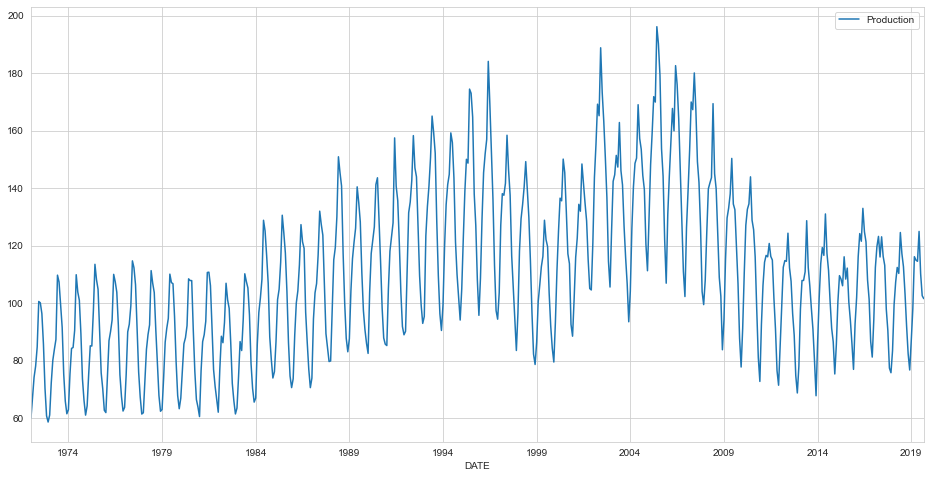

In [116]:
df.plot(figsize=(16,8));

In [83]:
df.duplicated().sum()

0

<AxesSubplot:xlabel='Production'>

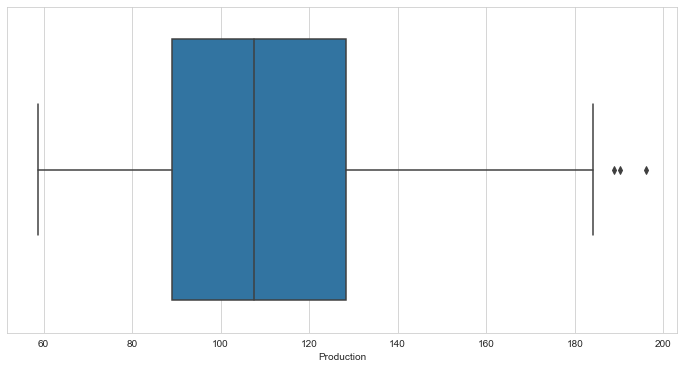

In [84]:
sns.boxplot(df['Production'])

## Preprocessing of Data

### Train Test Split

In [117]:
test_size = 24

In [118]:
test_ind = len(df) - test_size 
test_ind        

549

In [119]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:] 

In [89]:
train

,Production
DATE,
1972-01-01,59.962
1972-02-01,67.061
1972-03-01,74.235
1972-04-01,78.112
1972-05-01,84.764
...,...
2017-05-01,116.064
2017-06-01,123.087
2017-07-01,116.264


### Scaling

In [120]:
from sklearn.preprocessing import MinMaxScaler

In [121]:
scaler = MinMaxScaler()

In [122]:
train_scaled = scaler.fit_transform(train) 
test_scaled = scaler.transform(test)        

## Time Series Generator

In [123]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [125]:
length = 12
batch_size = 1
generator = TimeseriesGenerator(train_scaled, train_scaled, length = length, batch_size = batch_size)
validation_generator = TimeseriesGenerator(test_scaled, test_scaled, length = length, batch_size = batch_size)

In [126]:
generator[0]

(array([[[0.00947104],
         [0.06108982],
         [0.11326273],
         [0.14145625],
         [0.18982663],
         [0.30495972],
         [0.30154406],
         [0.27416065],
         [0.19736841],
         [0.08532665],
         [0.01561588],
         [0.        ]]]),
 array([[0.01774221]]))

In [127]:
X, y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.00947104 0.06108982 0.11326273 0.14145625 0.18982663 0.30495972
 0.30154406 0.27416065 0.19736841 0.08532665 0.01561588 0.        ]
Predict this y: 
 [[0.01774221]]


## Modelling & Model Performance

### Import related libraries

In [128]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping

### Creating Model

### with "tanh" activation function

In [129]:
n_features = train_scaled.shape[1]

In [131]:
model = Sequential()
model.add(LSTM(64, activation = 'tanh', return_sequences=True, input_shape = (length, n_features)))
model.add(LSTM(32, activation = 'tanh', return_sequences=True))
model.add(LSTM(16, activation = 'tanh'))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')

In [132]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 12, 64)            16896     
                                                                 
 lstm_8 (LSTM)               (None, 12, 32)            12416     
                                                                 
 lstm_9 (LSTM)               (None, 16)                3136      
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 32,465
Trainable params: 32,465
Non-trainable params: 0
_________________________________________________________________


In [133]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights = True)

In [134]:
model.fit(generator, epochs=50, callbacks=[early_stop], validation_data=validation_generator) 

Epoch 1/50
537/537 [==============================] - 40s 34ms/step - loss: 0.0250 - val_loss: 0.0035
Epoch 2/50
537/537 [==============================] - 12s 22ms/step - loss: 0.0093 - val_loss: 0.0018
Epoch 3/50
537/537 [==============================] - 9s 16ms/step - loss: 0.0062 - val_loss: 0.0029
Epoch 4/50
537/537 [==============================] - 8s 15ms/step - loss: 0.0058 - val_loss: 0.0041
Epoch 5/50
537/537 [==============================] - 8s 16ms/step - loss: 0.0052 - val_loss: 0.0020
Epoch 6/50
537/537 [==============================] - 8s 15ms/step - loss: 0.0053 - val_loss: 0.0023
Epoch 7/50
537/537 [==============================] - 8s 15ms/step - loss: 0.0048 - val_loss: 0.0044
Epoch 8/50
537/537 [==============================] - 9s 16ms/step - loss: 0.0042 - val_loss: 0.0040
Epoch 9/50
537/537 [==============================] - 8s 14ms/step - loss: 0.0044 - val_loss: 0.0029
Epoch 10/50
537/537 [==============================] - 8s 14ms/step - loss: 0.0043 - val_

<AxesSubplot:>

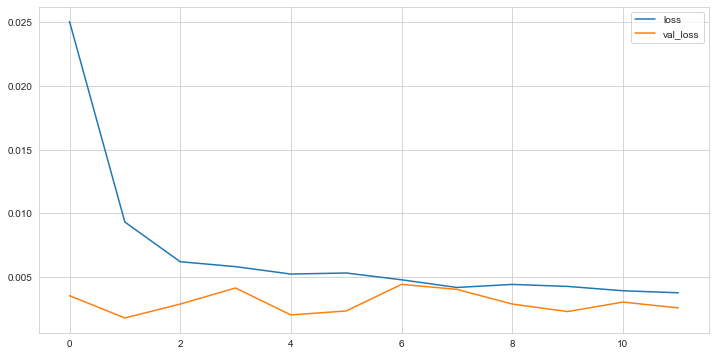

In [135]:
loss_df = pd.DataFrame(model.history.history)   
loss_df.plot()    

#### Evaluate on Test Data

In [136]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [137]:
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    mse = mean_squared_error(actual, pred)
    score = r2_score(actual, pred)
    return print("r2_score:", score, "\nmae:", mae, "\nmse:",mse, "\nrmse:",rmse)

In [138]:
predictions_scaled = []

first_eval_batch = train_scaled[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(length):
    
    # get prediction 1 time stamp ahead
    current_pred = model.predict(current_batch)
    
    # store prediction
    predictions_scaled.append(current_pred[0]) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [current_pred], axis=1)

#### Inverse Transformations and Comparing

In [139]:
predictions = scaler.inverse_transform(predictions_scaled)

In [142]:
compare = test[:12]
compare['Predictions_tanh'] = predictions
compare

,Production,Predictions_tanh
DATE,,
2017-10-01,90.473,91.172
2017-11-01,77.438,85.593
2017-12-01,75.812,91.495
2018-01-01,83.434,105.468
2018-02-01,99.490,116.884
2018-03-01,107.315,121.679
2018-04-01,112.431,123.588
2018-05-01,110.354,122.545
2018-06-01,124.584,122.330


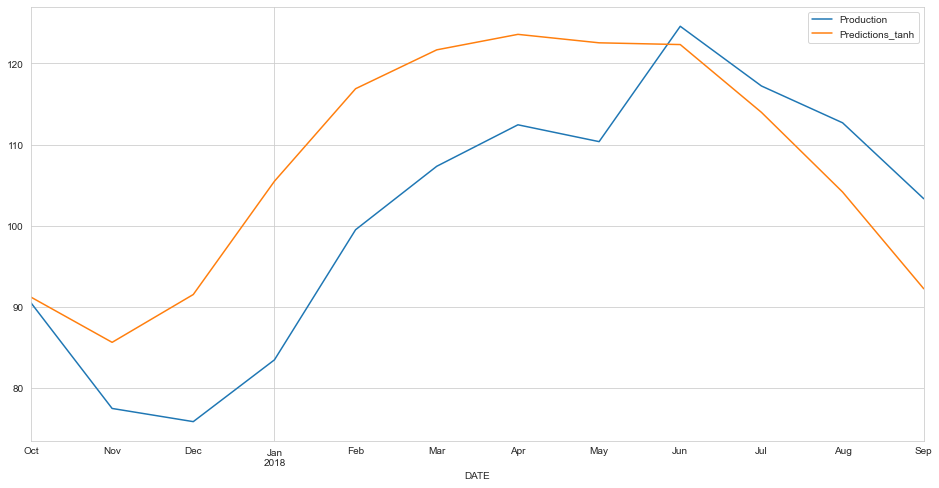

In [143]:
compare.plot(figsize=(16,8));

#### Calculation R2 Score and Error Metrics

In [145]:
eval_metrics(compare.Production, compare.Predictions_tanh)

r2_score: 0.36663050003137965 
mae: 10.569064160963395 
mse: 149.36163004902573 
rmse: 12.221359582674333


### with "relu" activation function

In [146]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [147]:
model = Sequential()
model.add(LSTM(64, activation = 'relu', return_sequences=True, input_shape = (length, n_features)))
model.add(LSTM(32, activation = 'relu', return_sequences=True))
model.add(LSTM(16, activation = 'relu'))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')

In [148]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 12, 64)            16896     
                                                                 
 lstm_11 (LSTM)              (None, 12, 32)            12416     
                                                                 
 lstm_12 (LSTM)              (None, 16)                3136      
                                                                 
 dense_6 (Dense)             (None, 1)                 17        
                                                                 
Total params: 32,465
Trainable params: 32,465
Non-trainable params: 0
_________________________________________________________________


In [150]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = 10, restore_best_weights = True)

In [151]:
model.fit(generator, epochs = 50, callbacks = [early_stop], validation_data = validation_generator)

Epoch 1/50
537/537 [==============================] - 24s 22ms/step - loss: 0.0333 - val_loss: 0.0065
Epoch 2/50
537/537 [==============================] - 12s 22ms/step - loss: 0.0147 - val_loss: 0.0022
Epoch 3/50
537/537 [==============================] - 7s 12ms/step - loss: 0.0102 - val_loss: 0.0029
Epoch 4/50
537/537 [==============================] - 6s 12ms/step - loss: 0.0091 - val_loss: 0.0040
Epoch 5/50
537/537 [==============================] - 6s 12ms/step - loss: 0.0089 - val_loss: 0.0019
Epoch 6/50
537/537 [==============================] - 6s 12ms/step - loss: 0.0073 - val_loss: 0.0028
Epoch 7/50
537/537 [==============================] - 7s 12ms/step - loss: 0.0073 - val_loss: 0.0098
Epoch 8/50
537/537 [==============================] - 7s 13ms/step - loss: 0.0077 - val_loss: 0.0062
Epoch 9/50
537/537 [==============================] - 7s 13ms/step - loss: 0.0065 - val_loss: 0.0031
Epoch 10/50
537/537 [==============================] - 6s 12ms/step - loss: 0.0057 - val_

<AxesSubplot:>

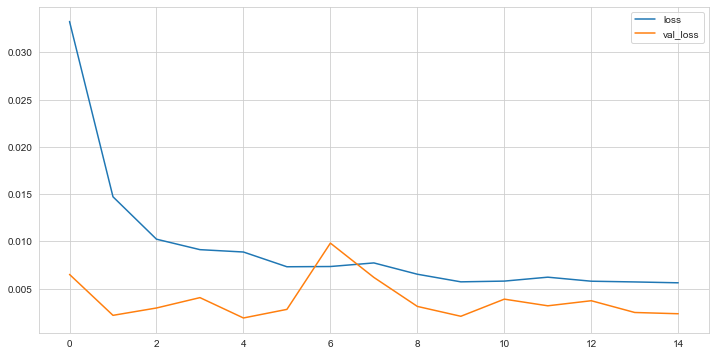

In [152]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

#### Evaluate on Test Data

In [153]:
predictions_scaled = []

first_eval_batch = train_scaled[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(length):
    
    # get prediction 1 time stamp ahead
    current_pred = model.predict(current_batch)
    
    # store prediction
    predictions_scaled.append(current_pred[0]) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [current_pred], axis=1)

In [154]:
eval_metrics(test_scaled[:length], predictions_scaled)

r2_score: 0.561409022392716 
mae: 0.06452857559410434 
mse: 0.00546950965988609 
rmse: 0.07395613334866886


#### Inverse Transformations and Comparing

In [155]:
predictions = scaler.inverse_transform(predictions_scaled)

In [156]:
compare['Predictions_relu'] = predictions
compare

,Production,Predictions_tanh,Predictions_relu
DATE,,,
2017-10-01,90.473,91.172,92.004
2017-11-01,77.438,85.593,86.593
2017-12-01,75.812,91.495,91.204
2018-01-01,83.434,105.468,101.631
2018-02-01,99.490,116.884,112.819
2018-03-01,107.315,121.679,117.689
2018-04-01,112.431,123.588,118.081
2018-05-01,110.354,122.545,117.939
2018-06-01,124.584,122.330,119.847


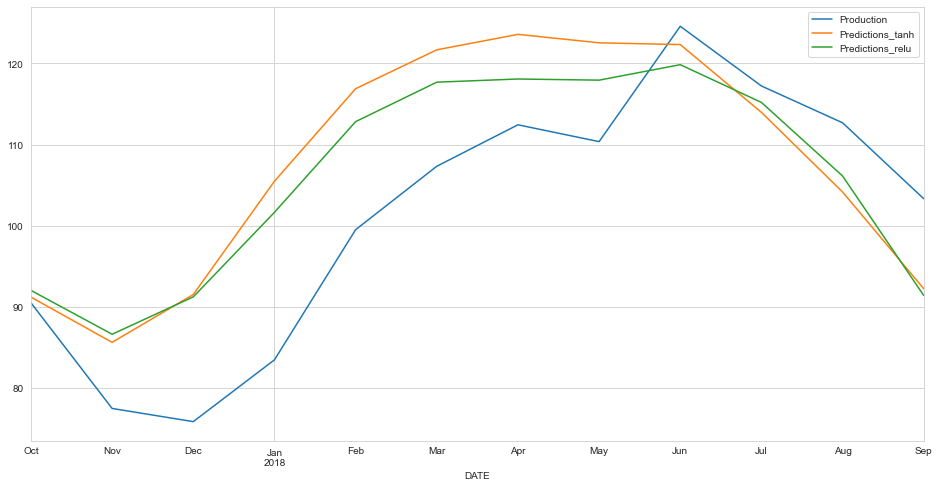

In [157]:
compare.plot(figsize=(16,8));

#### Calculation R2 Score and Error Metrics

In [158]:
eval_metrics(compare.Production, compare.Predictions_relu)

r2_score: 0.5614090223927162 
mae: 8.873576091390104 
mse: 103.42882526466023 
rmse: 10.169996325695513


## Retrain and Forecasting

Select activation function providing a better score, create your final model with full data, forecast for the next 12 months, and plot this forecast.

In [159]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [160]:
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length = length, batch_size = batch_size)

In [161]:
model = Sequential()

model.add(LSTM(64, activation = 'relu', return_sequences=True, input_shape = (length, n_features)))
model.add(LSTM(32, activation = 'relu', return_sequences=True))
model.add(LSTM(16, activation = 'relu'))
model.add(Dense(1))

model.compile(optimizer = 'adam', loss = 'mse')

model.fit_generator(generator, epochs=10)

Epoch 1/10
561/561 [==============================] - 27s 21ms/step - loss: 0.0298
Epoch 2/10
561/561 [==============================] - 7s 12ms/step - loss: 0.0154
Epoch 3/10
561/561 [==============================] - 7s 12ms/step - loss: 0.0087
Epoch 4/10
561/561 [==============================] - 7s 12ms/step - loss: 0.0074
Epoch 5/10
561/561 [==============================] - 7s 12ms/step - loss: 0.0067
Epoch 6/10
561/561 [==============================] - 7s 12ms/step - loss: 0.0075
Epoch 7/10
561/561 [==============================] - 7s 12ms/step - loss: 0.0068
Epoch 8/10
561/561 [==============================] - 7s 12ms/step - loss: 0.0066
Epoch 9/10
561/561 [==============================] - 7s 12ms/step - loss: 0.0060
Epoch 10/10
561/561 [==============================] - 7s 12ms/step - loss: 0.0058


In [162]:
forecast = []

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(length):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)
    
    # store prediction
    forecast.append(current_pred[0]) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [current_pred], axis = 1)

In [163]:
forecast = scaler.inverse_transform(forecast)

In [164]:
forecast_index = pd.date_range(start = '2019-10-01', periods = length, freq = 'MS')
forecast_index

DatetimeIndex(['2019-10-01', '2019-11-01', '2019-12-01', '2020-01-01',
               '2020-02-01', '2020-03-01', '2020-04-01', '2020-05-01',
               '2020-06-01', '2020-07-01', '2020-08-01', '2020-09-01'],
              dtype='datetime64[ns]', freq='MS')

In [165]:
forecast_df = pd.DataFrame(data = forecast, index = forecast_index, columns = ['Forecast'])

In [166]:
forecast_df

,Forecast
2019-10-01,93.813
2019-11-01,82.106
2019-12-01,79.639
2020-01-01,89.315
2020-02-01,101.347
2020-03-01,114.604
2020-04-01,115.843
2020-05-01,121.365
2020-06-01,125.742
2020-07-01,115.765


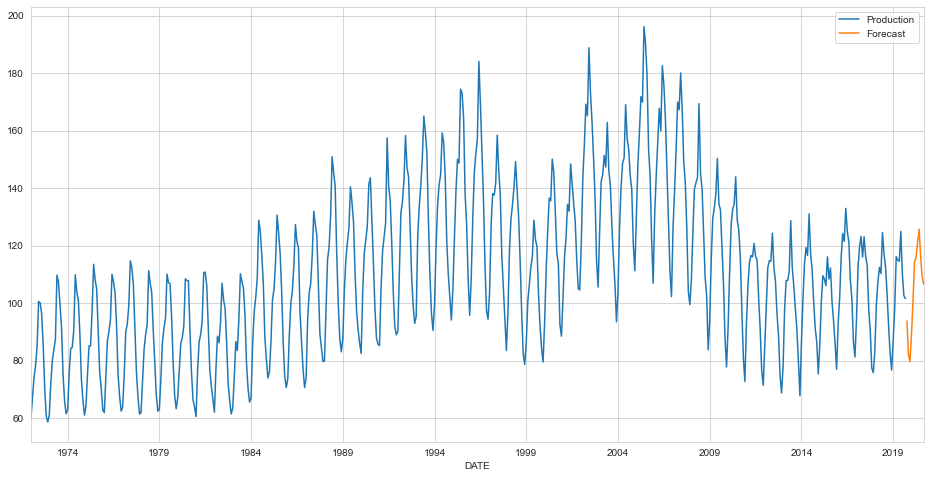

In [167]:
ax = df.plot()
forecast_df.plot(ax = ax, figsize = (16, 8));

(576.0, 620.0)

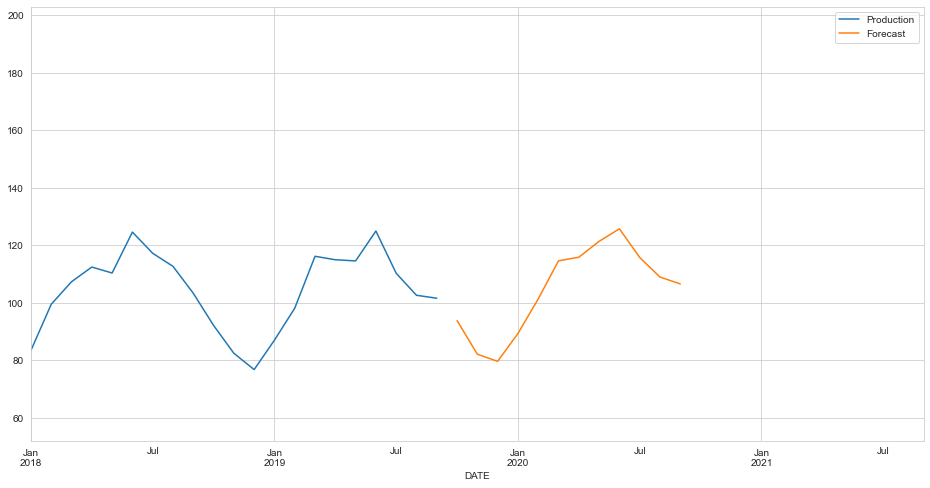

In [168]:
ax = df.plot()
forecast_df.plot(ax = ax, figsize = (16, 8))
plt.xlim('2018-01-01', '2021-09-01')